# Binary Classification
This notebook will approach the popularity prediction task as a binary classification problem. The videos will either be classified as viral or non-viral

In [1]:
%cd ..

C:\Users\georg\Documents\msc-project


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn import neighbors, svm, linear_model,dummy,ensemble
from sklearn.metrics import make_scorer, precision_score, recall_score,f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from src.evaluation import compare_models
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline

In [3]:
df = pd.read_csv("data/interim/tracks_clean.csv")

The threshold chosen for the viral videos will be 1e+06, as most videos seem to be below this threshold.

<AxesSubplot:ylabel='View count'>

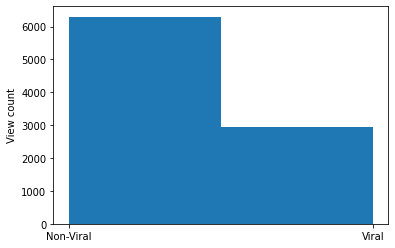

In [4]:
viral_threshold = 1e+06
features = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature',
    'duration_ms',
    'popularity'
]

def get_data_for_threshold(threshold):
    views = df['views']
    data = df.loc[:,features]
    targets = views.apply(np.digitize,bins=[0,threshold,views.max() +1])

    return data, targets

data, targets = get_data_for_threshold(viral_threshold)
plt.xticks([1,2],["Non-Viral","Viral"])
plt.ylabel("View count")
targets.hist(bins=2, grid=False)

## Model Comparison
Similar to the multiclass classification task, multiple models are evaluated and compared

In [5]:
models = [
    ("Baseline",dummy.DummyClassifier(strategy='stratified')),
    ("5-KNN",neighbors.KNeighborsClassifier(n_neighbors=5)),
    ("10-KNN",neighbors.KNeighborsClassifier(n_neighbors=10)),
    ("SVM Linear", svm.SVC(kernel='linear')),
    ("SVM RBF", svm.SVC(kernel='rbf')),
    ("Random Forest",ensemble.RandomForestClassifier()),
    ("Logistic Regression",linear_model.LogisticRegression())
]

oversampled_models = []
for name, model in models:
    combined = make_pipeline(
        ADASYN(),
        model
    )
    oversampled_models.append((name,combined))
    
metrics = {
    'precision': make_scorer(precision_score,average='macro',zero_division=0),
    'recall': make_scorer(recall_score,average='macro'),
    'f1': make_scorer(f1_score,average='macro')
}
compare_models(oversampled_models, metrics, data, targets)

Evaluating Baseline
Evaluating 5-KNN
Evaluating 10-KNN
Evaluating SVM Linear
Evaluating SVM RBF
Evaluating Random Forest
Evaluating Logistic Regression


,model,fit_time,score_time,test_precision,test_recall,test_f1
0,Baseline,0.534687,0.004564,0.496143,0.495562,0.481043
1,5-KNN,0.586652,0.454953,0.531840,0.536605,0.516033
2,10-KNN,0.572868,0.491548,0.540013,0.545094,0.534656
3,SVM Linear,5.845238,0.340875,0.587034,0.596557,0.550089
4,SVM RBF,5.036466,1.585821,0.578239,0.589514,0.568031
5,Random Forest,2.696661,0.049591,0.557292,0.553977,0.554315
6,Logistic Regression,0.543200,0.004377,0.591917,0.604213,0.575245


Logistic regression appears to outperform the rest of the models, although not by a significant margin

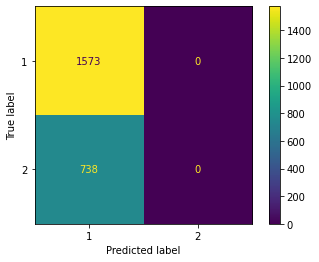

In [10]:
X_train, X_test, y_train,y_test = train_test_split(data, targets)
X_train, y_train = ADASYN().fit_resample(X_train,y_train)
model = linear_model.SVC(kernel='linear')
model.fit(X_train,y_train)
predicted = model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test,predicted)